In [47]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor

# 전처리

In [2]:
data = pd.read_csv('World Bank Development Indicators.csv')
data.head()

,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,...,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides
0,Afghanistan,1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,50.340,31.921,32.535,8622466.0,7898093.0,NaN,NaN,NaN
1,Afghanistan,1961-01-01,57.801696,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,50.443,31.349,33.068,8790140.0,8026804.0,NaN,NaN,NaN
2,Afghanistan,1962-01-01,57.893688,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,50.570,30.845,33.547,8969047.0,8163985.0,NaN,NaN,NaN
3,Afghanistan,1963-01-01,57.970348,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,50.703,30.359,34.016,9157465.0,8308019.0,NaN,NaN,NaN
4,Afghanistan,1964-01-01,58.066940,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,50.831,29.867,34.494,9355514.0,8458694.0,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13140 entries, 0 to 13139
Data columns (total 50 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    13140 non-null  object 
 1   date                                       13140 non-null  object 
 2   agricultural_land%                         12013 non-null  float64
 3   forest_land%                               6213 non-null   float64
 4   land_area                                  12253 non-null  float64
 5   avg_precipitation                          7823 non-null   float64
 6   trade_in_services%                         7176 non-null   float64
 7   control_of_corruption_estimate             3527 non-null   float64
 8   control_of_corruption_std                  3527 non-null   float64
 9   access_to_electricity%                     5765 non-null   float64
 10  renewvable_energy_cons

In [4]:
delete_country = ['Africa Eastern and Southern', 'Africa Western and Central', 'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', 'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)', 'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'European Union', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)', 'Latin America & the Caribbean (IDA & IBRD countries)', 'Least developed countries: UN classification', 'Low & middle income', 'Low income', 'Lower middle income', 'Middle East & North Africa', 'Middle East & North Africa (IDA & IBRD countries)', 'Middle East & North Africa (excluding high income)', 'Middle income', 'Not classified', 'OECD members', 'Other small states', 'Pacific island small states', 'Post-demographic dividend', 'Pre-demographic dividend', 'Small states', 'South Asia', 'South Asia (IDA & IBRD)', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)', 'Turkey', 'United Kingdom', 'Upper middle income', 'World']

In [5]:
data = data[~data['country'].isin(delete_country)]

In [6]:
data = data.drop(['control_of_corruption_std', 'goverment_effectiveness_std', 'political_stability_std', 'rule_of_law_std', 'regulatory_quality_std', 'voice_and_accountability_std'], axis=1)

In [7]:
data = pd.concat([data.drop('intentional_homicides',axis=1).groupby('country',group_keys=False).apply(lambda group: group.interpolate(method='linear', limit_direction='both')),data['intentional_homicides']],axis=1)

In [8]:
data = pd.concat([data.drop('intentional_homicides',axis=1).fillna(data.mean()),data['intentional_homicides']],axis=1)

<ipython-input-8-1c362199e024>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = pd.concat([data.drop('intentional_homicides',axis=1).fillna(data.mean()),data['intentional_homicides']],axis=1)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10620 entries, 0 to 13139
Data columns (total 44 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    10620 non-null  object 
 1   date                                       10620 non-null  object 
 2   agricultural_land%                         10620 non-null  float64
 3   forest_land%                               10620 non-null  float64
 4   land_area                                  10620 non-null  float64
 5   avg_precipitation                          10620 non-null  float64
 6   trade_in_services%                         10620 non-null  float64
 7   control_of_corruption_estimate             10620 non-null  float64
 8   access_to_electricity%                     10620 non-null  float64
 9   renewvable_energy_consumption%             10620 non-null  float64
 10  electric_power_consump

In [10]:
df = data.dropna(axis=0, subset='intentional_homicides')
df = df.drop(['country', 'date'],axis=1)
df = df.reset_index(drop=True)
df

,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,access_to_electricity%,renewvable_energy_consumption%,electric_power_consumption,CO2_emisions,...,government_health_expenditure%,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,intentional_homicides
0,58.123668,1.852782,652230.0,327.0,21.004203,-1.552299,48.279007,16.53,3109.093744,6558.97,...,0.531904,51.700000,39.99313,41.157,8.535,60.364,27385307.0,20942092.0,-1.375495,4.071526
1,58.125201,1.852782,652230.0,327.0,20.554144,-1.645391,42.700000,15.15,3109.093744,8576.15,...,0.469157,51.700000,39.99313,40.602,8.254,60.851,28189672.0,21498290.0,-1.404467,3.487093
2,58.123668,1.852782,652230.0,327.0,22.839950,-1.600471,43.222019,12.61,3109.093744,11961.89,...,0.480000,51.700000,39.99313,39.855,7.931,61.419,29249157.0,22244569.0,-1.335977,4.208668
3,58.123668,1.852782,652230.0,327.0,17.982843,-1.430373,69.100000,15.36,3109.093744,10208.13,...,0.342887,51.700000,39.99313,40.009,7.711,61.923,30466479.0,23105778.0,-1.267430,6.393913
4,58.123668,1.852782,652230.0,327.0,10.278594,-1.348587,71.500000,17.53,3109.093744,10057.59,...,0.522673,51.700000,39.99313,38.803,7.331,62.659,33753499.0,25381619.0,-1.117557,9.975262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,80.810256,0.454484,2149690.0,59.0,13.546819,-0.103524,100.000000,0.01,6457.385803,315293.20,...,2.478365,34.230197,39.99313,23.058,2.879,74.588,24397644.0,4640676.0,-1.536319,1.217331
3064,80.790253,0.454484,2149690.0,59.0,16.900283,-0.195400,100.000000,0.01,6604.296520,335434.30,...,2.641391,34.230197,39.99313,23.114,2.797,74.810,25382870.0,4770964.0,-1.781469,1.004615
3065,80.790719,0.454484,2149690.0,59.0,19.100281,-0.169474,100.000000,0.01,6622.899608,354617.40,...,2.507401,34.230197,39.99313,23.242,2.719,75.046,26400068.0,4903285.0,-1.705147,1.003785
3066,80.753931,0.454484,2149690.0,59.0,12.341491,0.355427,99.890000,0.01,9047.685513,527565.70,...,3.892339,34.230197,39.99313,18.703,2.655,77.212,35018133.0,5657530.0,-1.695982,0.639669


# EDA

<ipython-input-11-92a006646bbc>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax[int(i/6),int(i%6)])
<ipython-input-11-92a006646bbc>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col], ax=ax[int(i/6),int(i%6)])
<ipython-input-11-92a006646bbc>:4: UserWarning: 

`distplot` is 

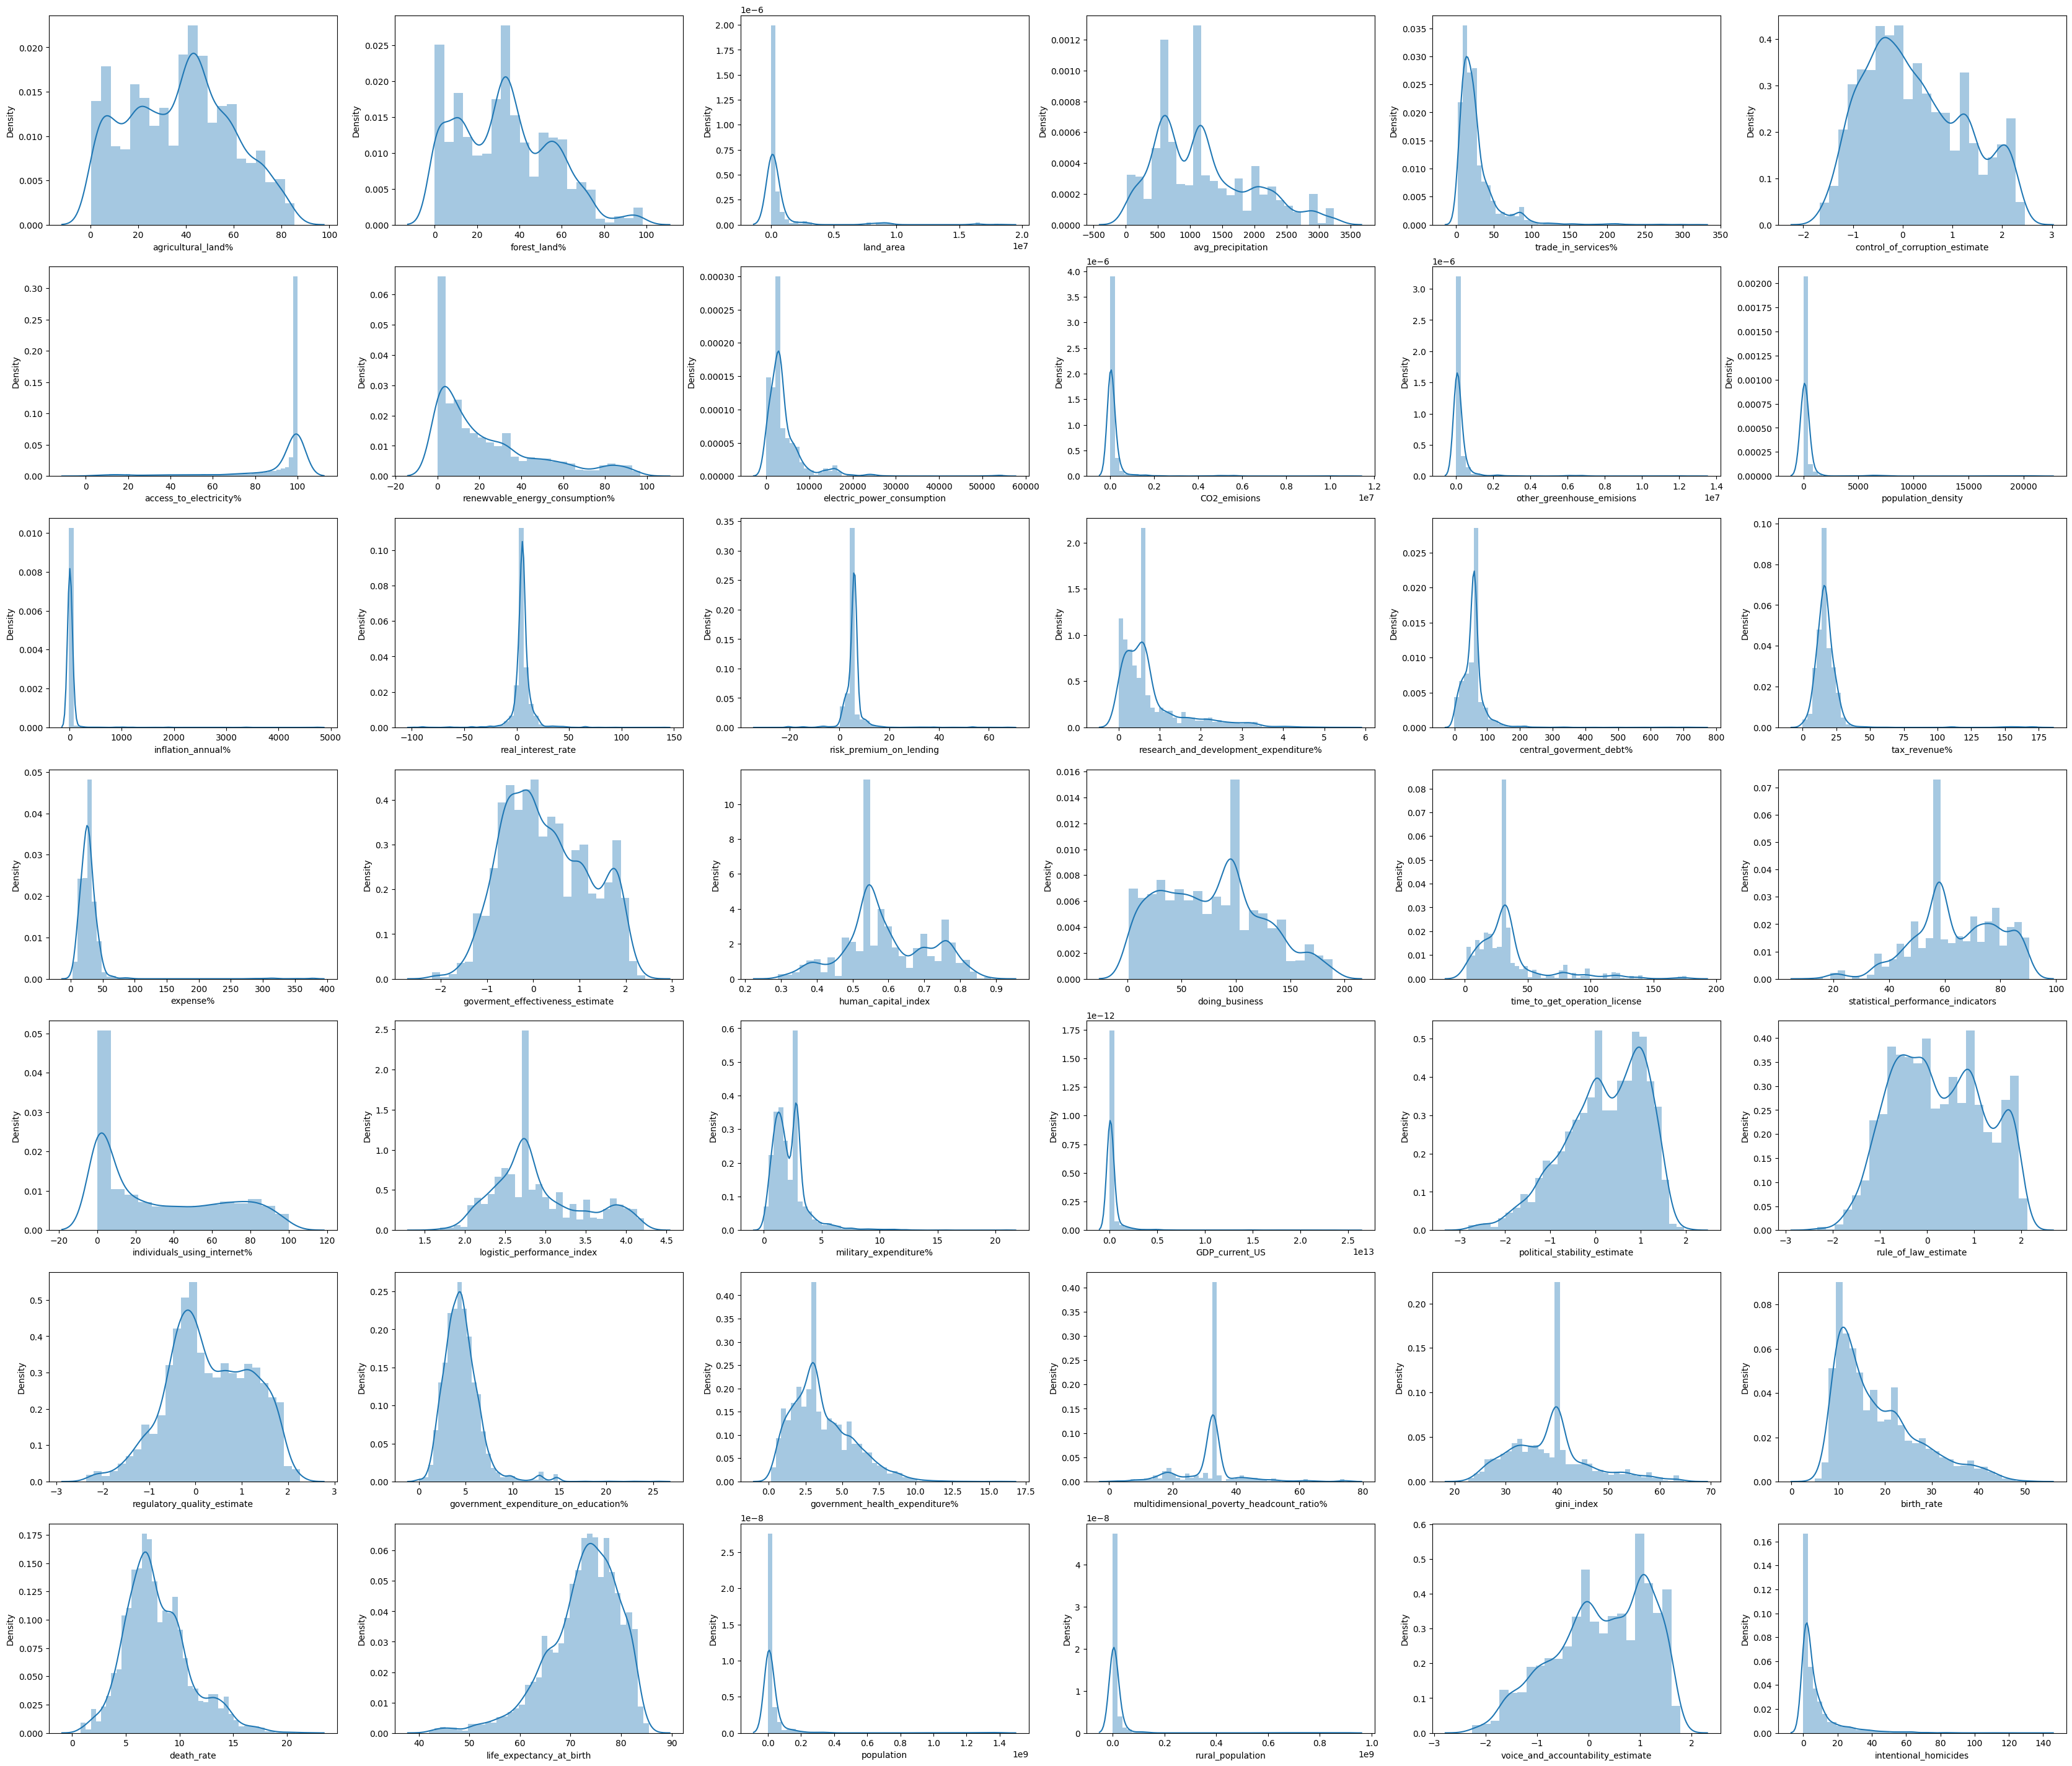

In [ ]:
fig, ax = plt.subplots(nrows=7, ncols=6, figsize=(42,36))

for i,col in enumerate(df.columns):
    sns.distplot(df[col], ax=ax[int(i/6),int(i%6)])

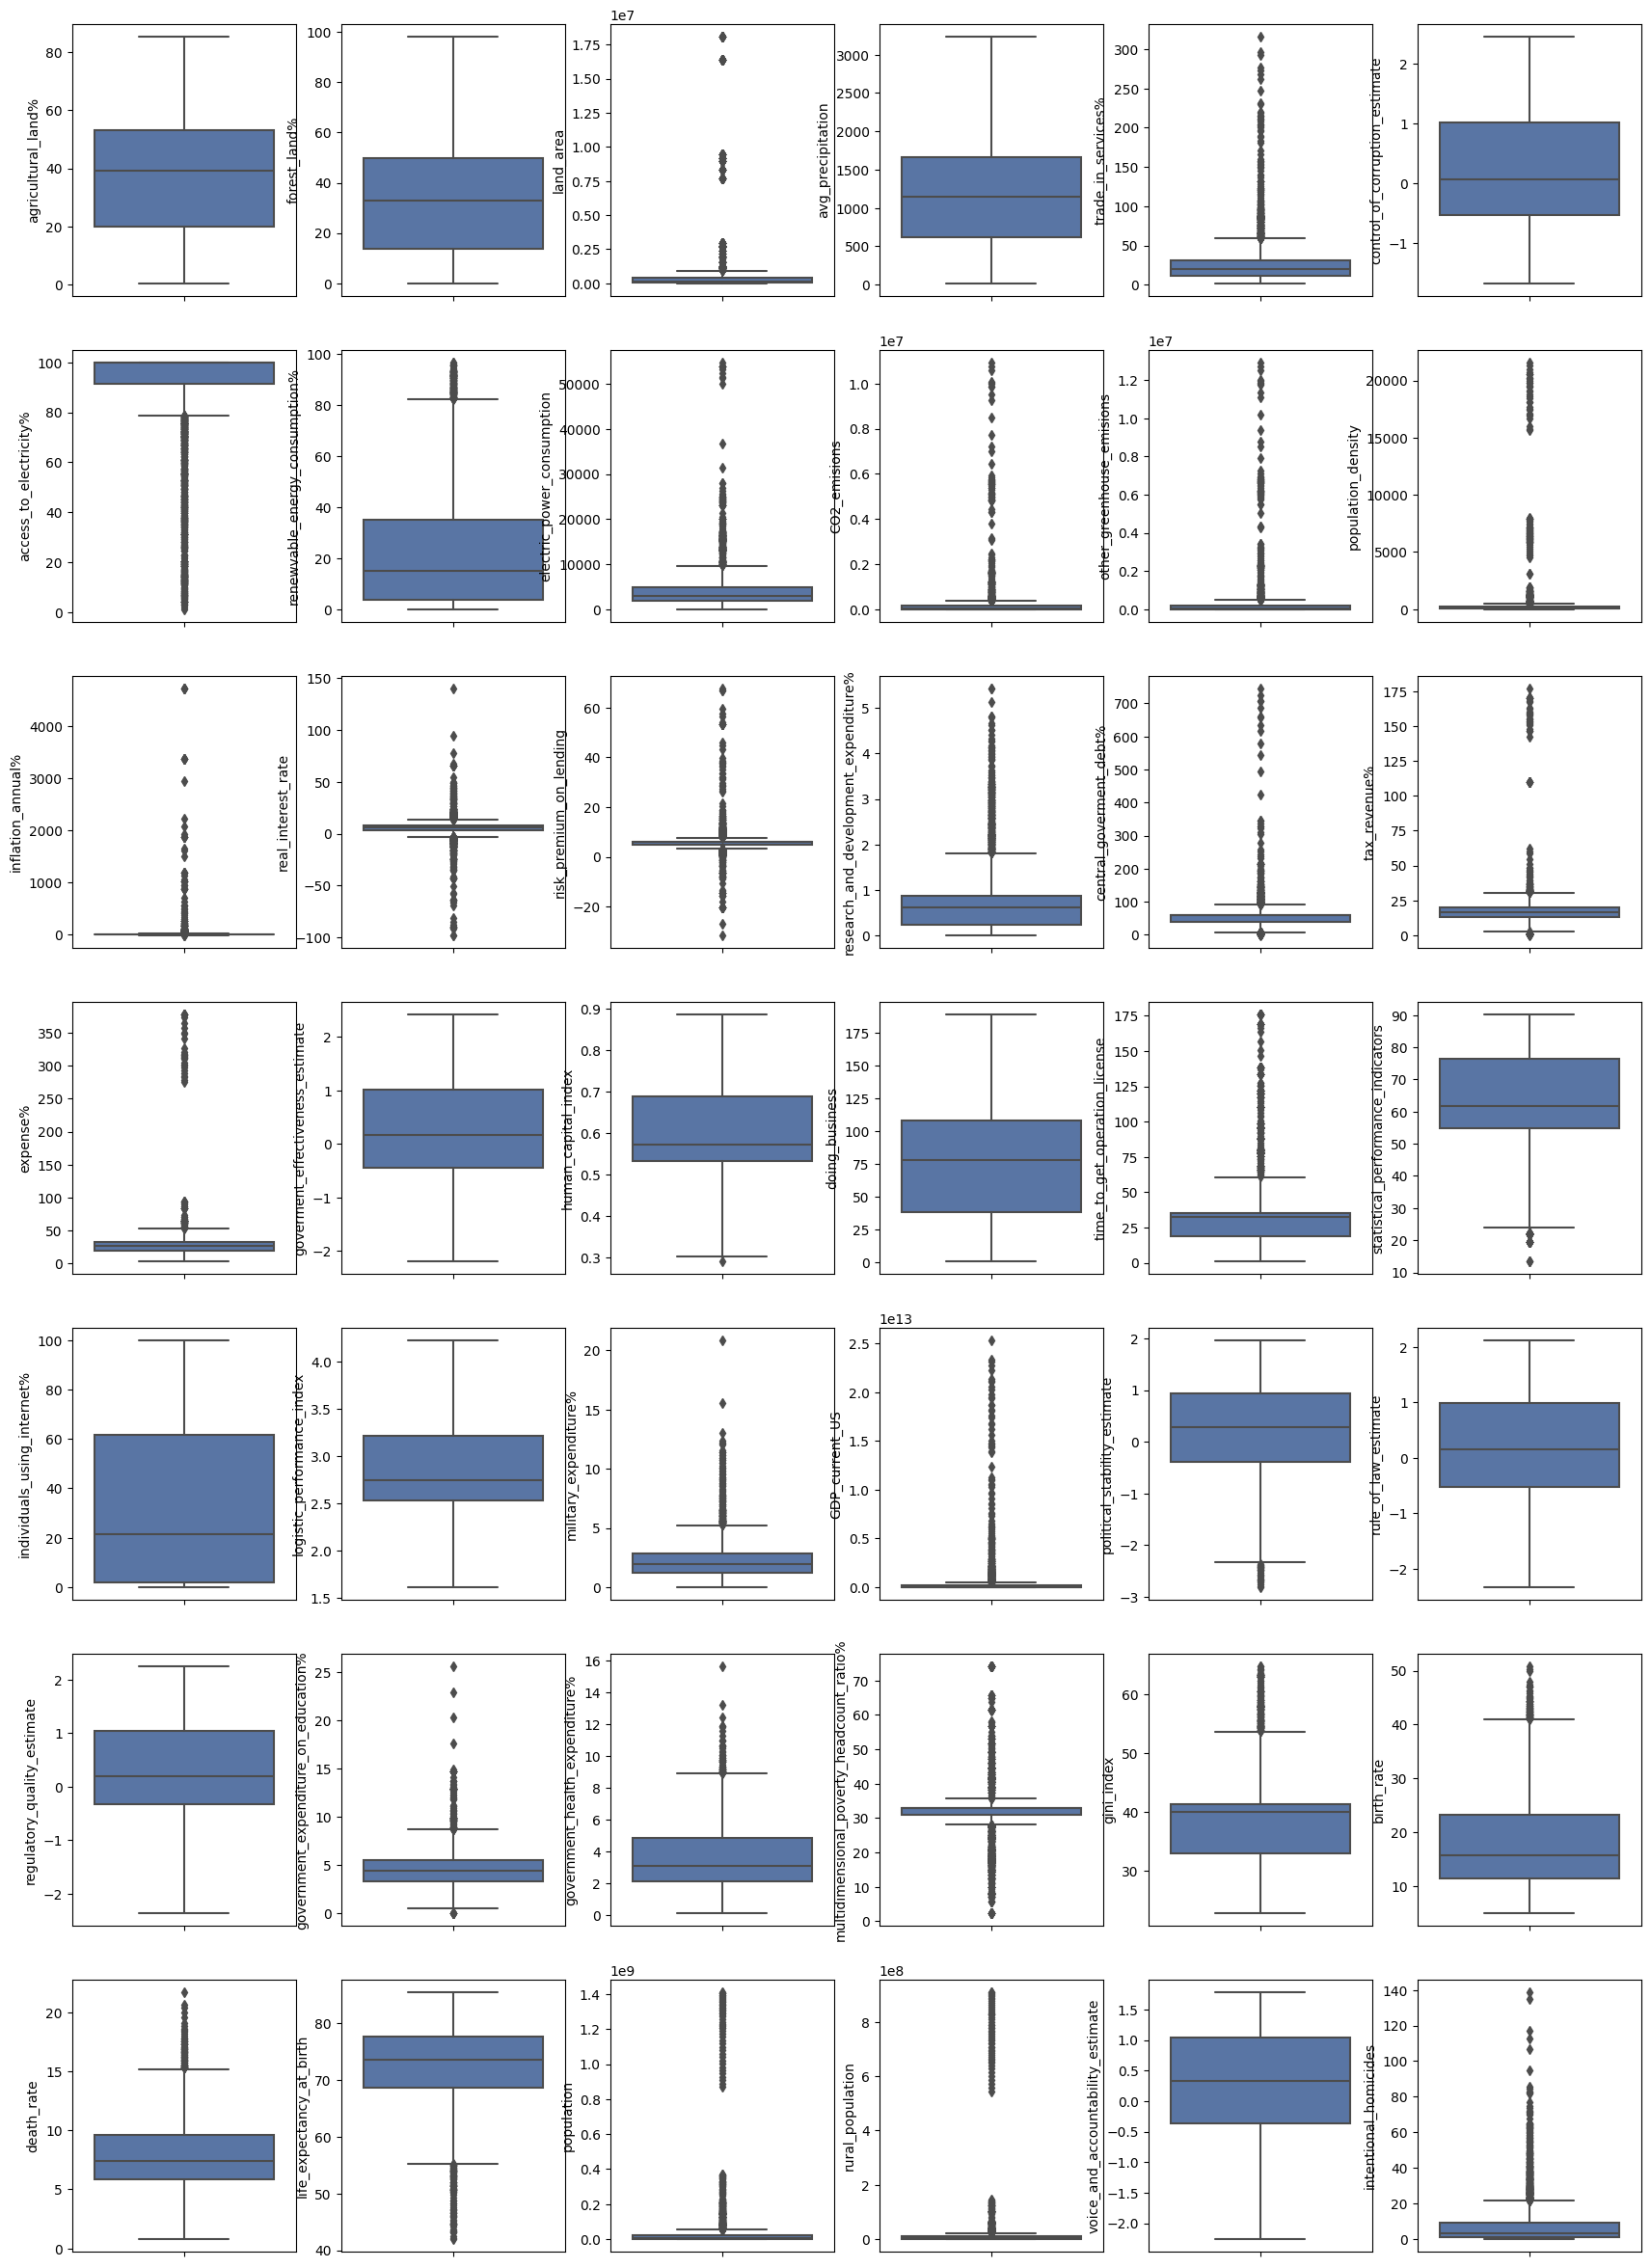

In [ ]:
fig, ax = plt.subplots(nrows = 7, ncols = 6, figsize=(21, 30))

for i, col in enumerate(df.columns):
  sns.set_theme(style ='whitegrid')
  sns.boxplot(y = col, data = df, ax = ax[int(i/6), int(i%6)])

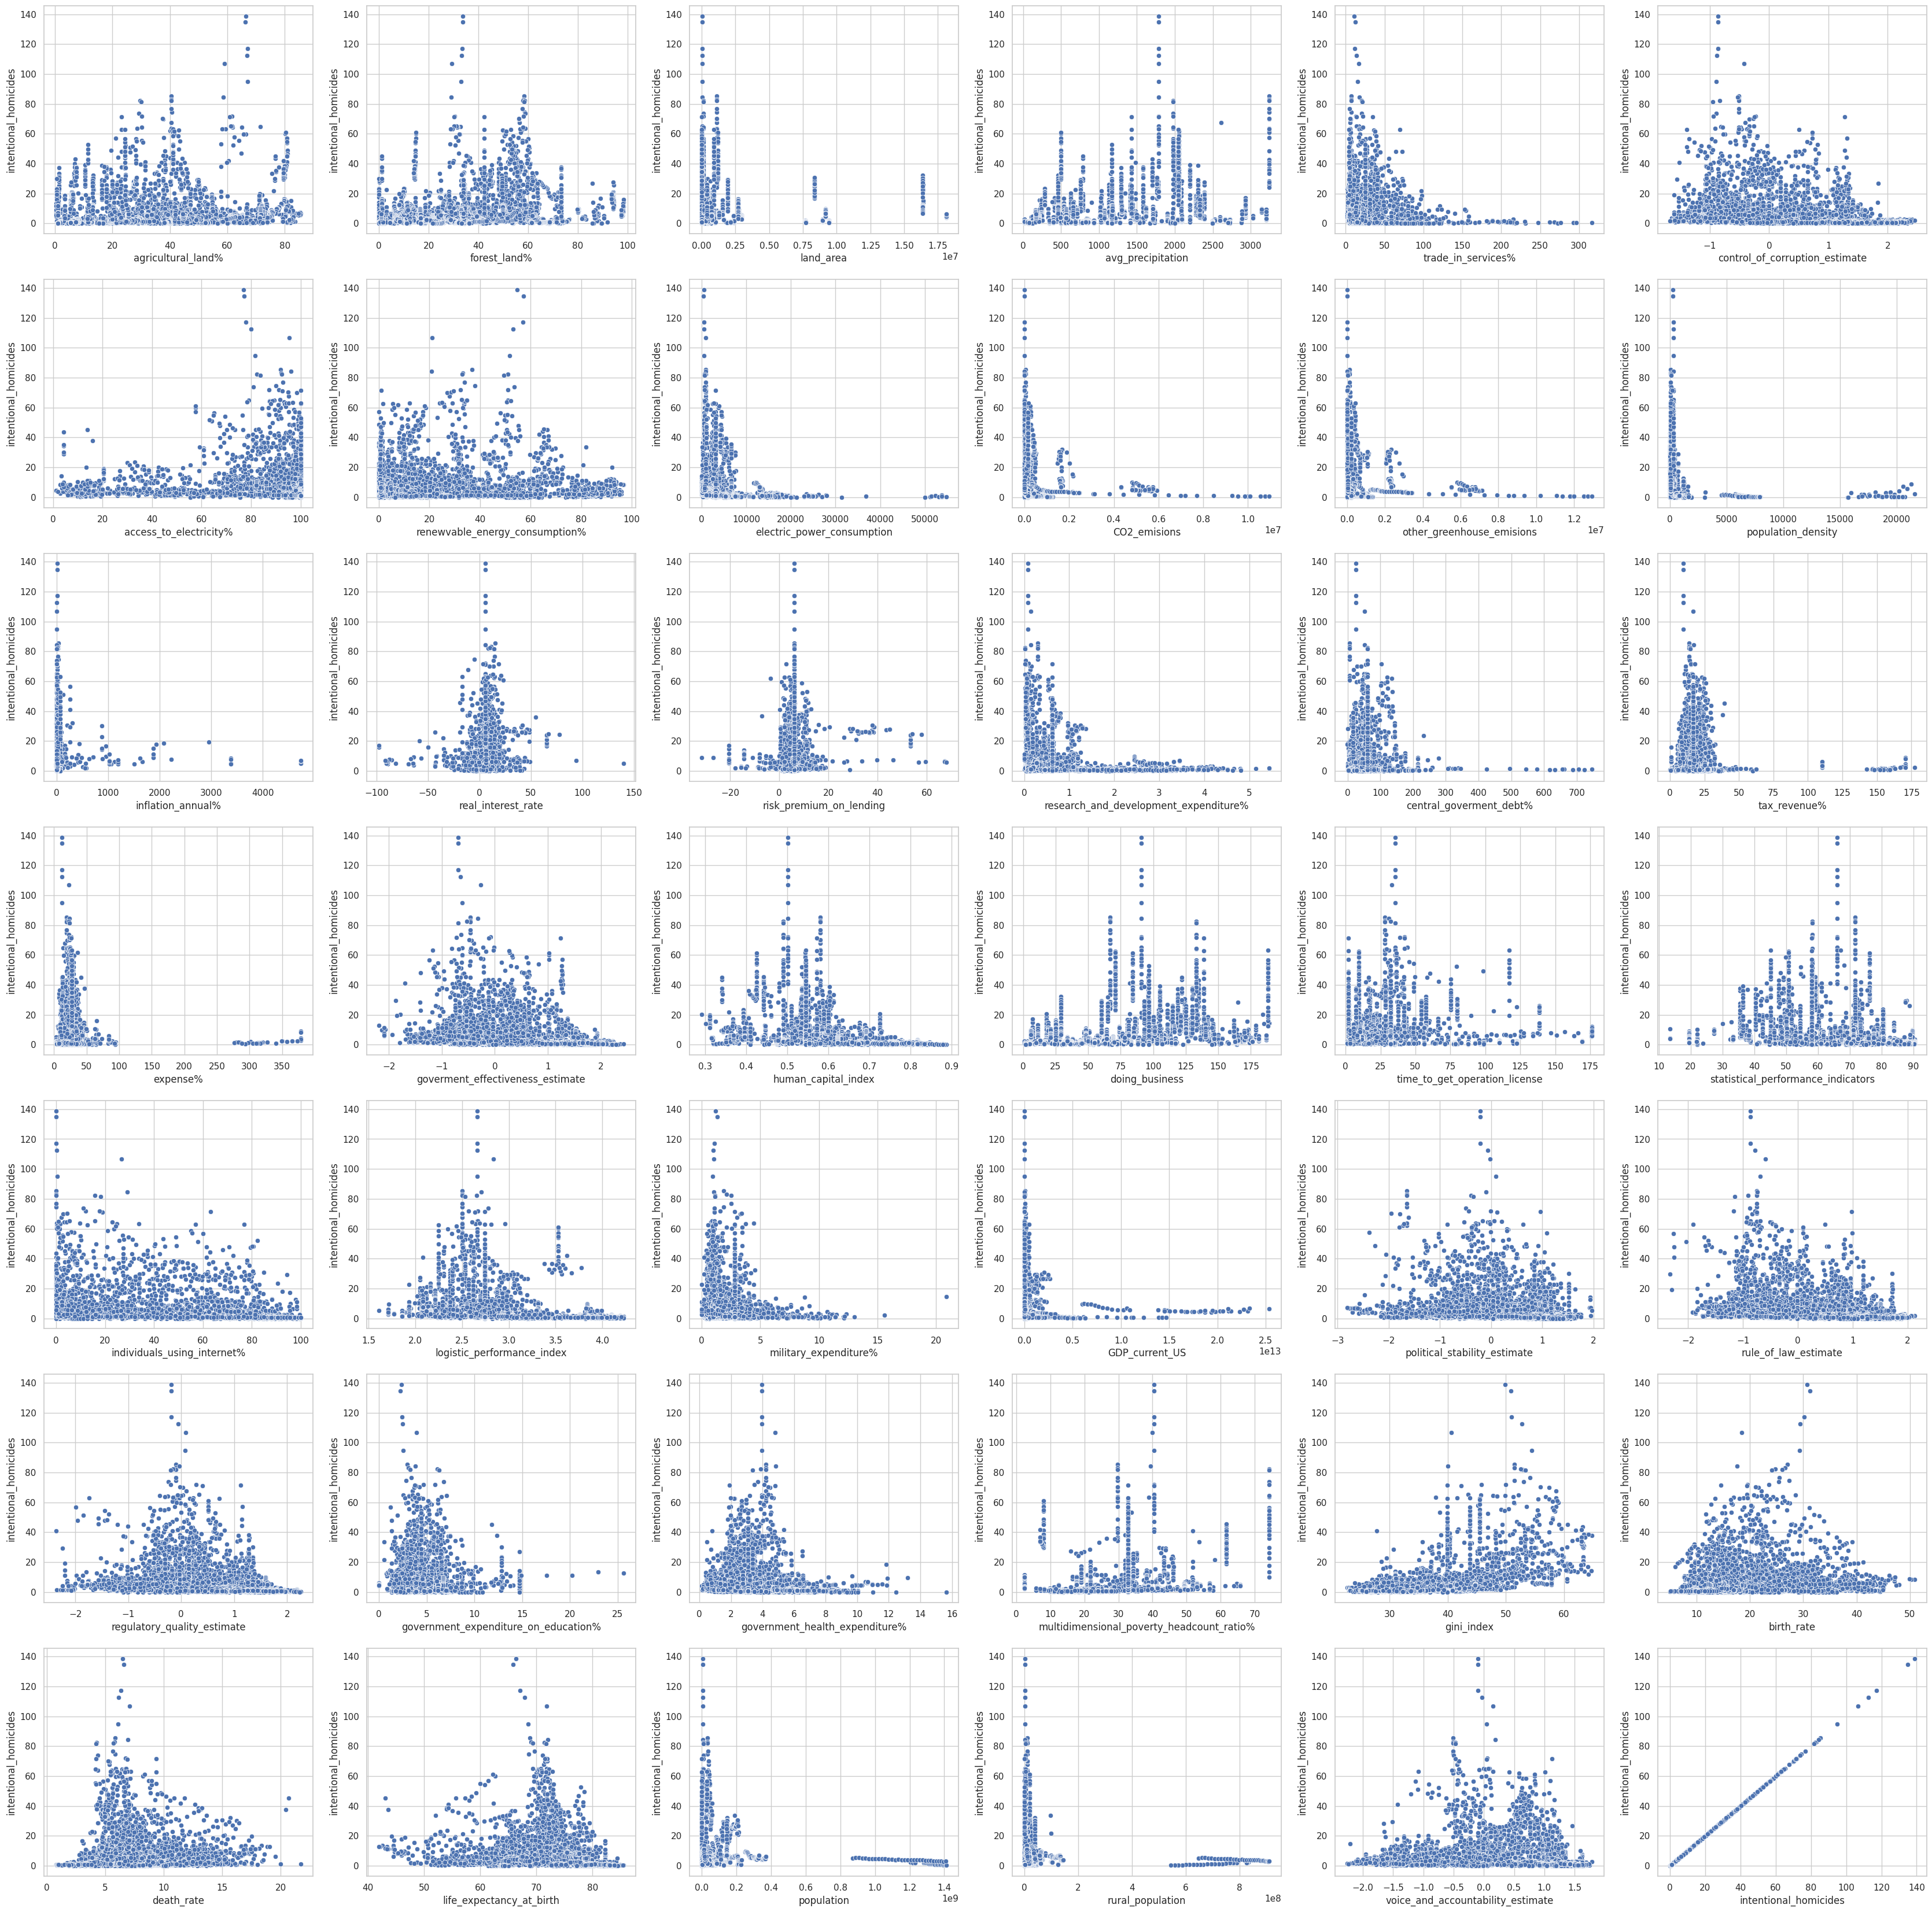

In [ ]:
fig, ax = plt.subplots(nrows = 7, ncols = 6, figsize=(42,42))

for i,col in enumerate(df.columns):
    sns.scatterplot(x=col, y='intentional_homicides', data=df, ax=ax[int(i/6),int(i%6)])

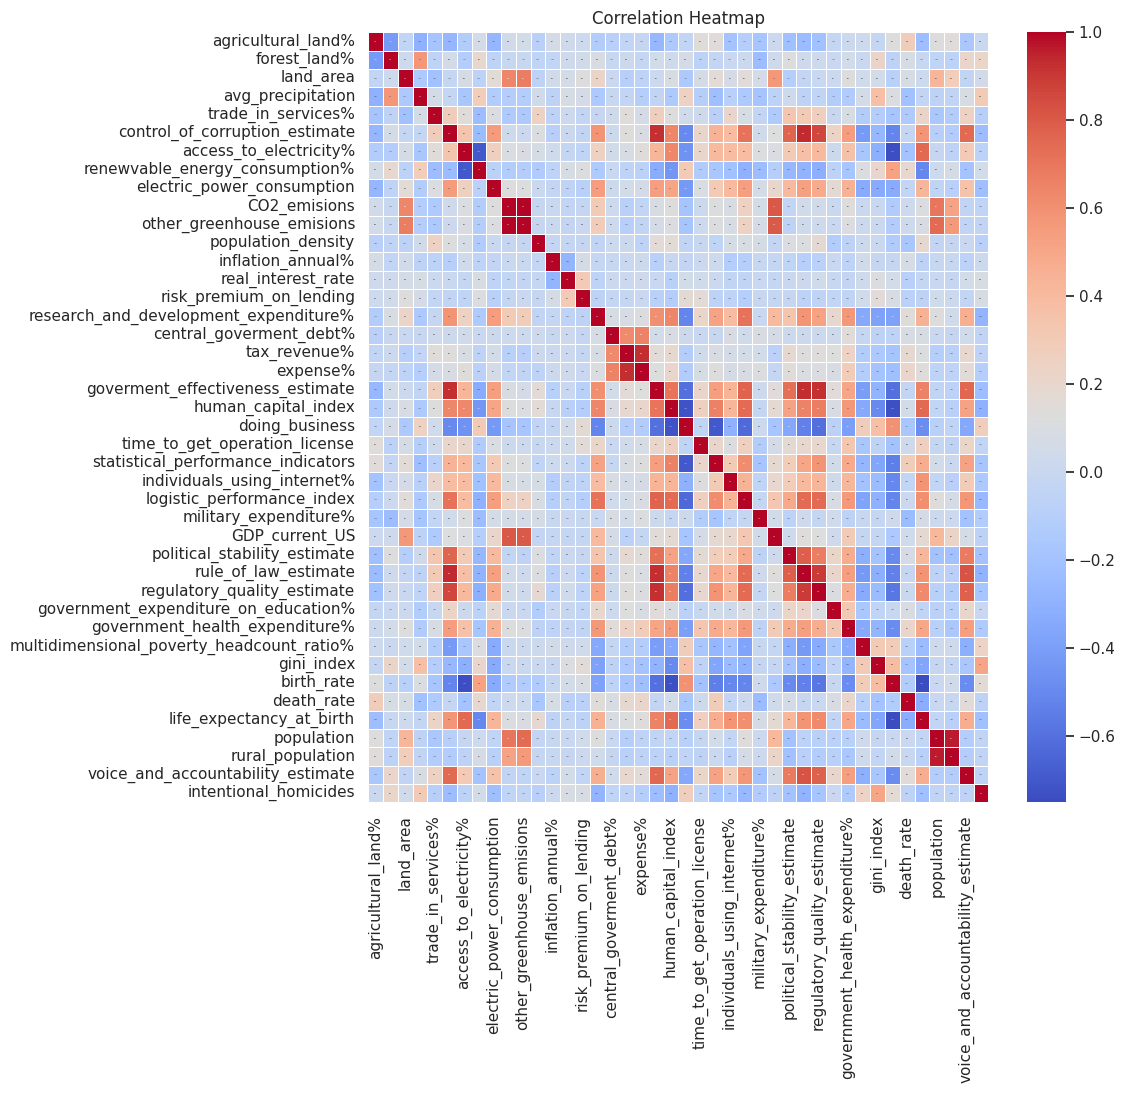

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,annot_kws={'size': 1})
plt.title('Correlation Heatmap')
plt.show()

# 변수 변환

In [ ]:
# MinMaxScaling 함수
def MinMax(dataframe):
  X = dataframe.drop(['intentional_homicides'], axis = 1)
  y = dataframe['intentional_homicides']

  # fitting
  MmScaler =  MinMaxScaler()
  MmScaler.fit(X)
  # transform
  data_minmax = MmScaler.transform(X)
  # dataframe
  df_minmax = pd.DataFrame(data_minmax, columns = X.columns)
  df_new = pd.concat([df_minmax, y], axis = 1)

  return df_new

In [ ]:
# SkewScaling 함수
def SkewScaling(dataframe):

  X = dataframe.drop(['intentional_homicides'], axis = 1)
  y = dataframe['intentional_homicides']

  logList = []
  normalList = []

  for col in X.columns:
    if(skew(X[col]) > 3): # 왜도 > 0 : 왼쪽으로 치우친 분포
      logList.append(col)
    else:
      normalList.append(col)

  # log_transformation
  alpha = abs(X.loc[:, logList].min().min())+1
  df_log = np.log(X.loc[:, logList] + alpha)

  df_normal = X.loc[:, normalList]

  df_new = pd.concat([df_log, df_normal, y], axis=1)

  return df_new

In [ ]:
df_mm = MinMax(df)
df_log = SkewScaling(df)
df_log_mm = MinMax(SkewScaling(df))

# 모델링

## RandomForest

In [16]:
# RF 그리드 서치 함수
def Tuning_RF(data, params, cv_iter):

  X = data.drop(['intentional_homicides'], axis = 1)
  y = data['intentional_homicides']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=444)

  rf = RandomForestRegressor(random_state=444)

  rf_grid = GridSearchCV(rf, param_grid=params, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=cv_iter, shuffle=True, random_state=444))
  rf_grid.fit(X_train, y_train)

  print('GridSearchCV best hyper-params :', rf_grid.best_params_)
  print('GridSearchCV best rmse score : {0:.4f}'.format(-1*rf_grid.best_score_))

  return(rf_grid.best_params_)

In [27]:
# RF 하이퍼 파라미터 튜닝
rf_params = {'n_estimators' : [450], 'max_depth' : [15], 'max_features' : [0.3]} # max_features 1.0까지

rf_best_params = Tuning_RF(data = df, params = rf_params, cv_iter = 10)

GridSearchCV best hyper-params : {'max_depth': 15, 'max_features': 0.3, 'n_estimators': 450}
GridSearchCV best rmse score : 3.3441


In [28]:
# RF 모델 적합
def MY_RF(data, cv_iter, parameters):

  X = np.array(data.drop(['intentional_homicides'], axis = 1))
  y = data['intentional_homicides']

  # modeling part
  rf = RandomForestRegressor(random_state=444)
  rf.set_params(**parameters)

  # fit&predict with cross_validation part
  kfold = KFold(n_splits=cv_iter, shuffle=True, random_state=444)
  rmse_scores = []

  for train_idx, test_idx in kfold.split(X):
      X_train, X_test = X[train_idx], X[test_idx]
      y_train, y_test = y[train_idx], y[test_idx]
      rf.fit(X_train, y_train)
      pred = rf.predict(X_test)
      rmse = np.sqrt(MSE(y_test, pred))
      rmse_scores.append(rmse)

  # gain mean evaluation
  mean_rmse_score = np.mean(rmse_scores)
  print('CV {0} result : Mean RMSE : {1:.4f}'.format(cv_iter, mean_rmse_score))

In [29]:
MY_RF(data = df, cv_iter = 10, parameters = rf_best_params)

CV 10 result : Mean RMSE : 2.9267


## LightGBM

In [23]:
# LGBM 그리드 서치 함수
def Tuning_LGBM(data, params, cv_iter):

  X = data.drop(['intentional_homicides'], axis = 1)
  y = data['intentional_homicides']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=444)

  lgbm = LGBMRegressor(random_state=444)

  lgbm_grid = GridSearchCV(lgbm, param_grid=params, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=cv_iter, shuffle=True, random_state=444))
  lgbm_grid.fit(X_train, y_train)

  print('GridSearchCV best hyper-params :', lgbm_grid.best_params_)
  print('GridSearchCV best rmse score : {0:.4f}'.format(-1*lgbm_grid.best_score_))

  return(lgbm_grid.best_params_)

In [30]:
# LGBM 하이퍼 파라미터 튜닝
lgbm_params = {'n_estimators' : [600], 'num_leaves' : [30], 'max_depth' : [10], 'learning_rate' : [0.1], 'reg_lambda' : [30]}

lgbm_best_params = Tuning_LGBM(data = df, params = lgbm_params, cv_iter = 10)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10018
[LightGBM] [Info] Number of data points in the train set: 2208, number of used features: 41
[LightGBM] [Info] Start training from score 7.804355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [31]:
# LGBM 모델 적합
def MY_LGBM(data, cv_iter, parameters):

  X = np.array(data.drop(['intentional_homicides'], axis = 1))
  y = data['intentional_homicides']

  # modeling part
  lgbm = LGBMRegressor(random_state=444)
  lgbm.set_params(**parameters)

  # fit&predict with cross_validation part
  kfold = KFold(n_splits=cv_iter, shuffle=True, random_state=444)
  rmse_scores = []

  for train_idx, test_idx in kfold.split(X):
      X_train, X_test = X[train_idx], X[test_idx]
      y_train, y_test = y[train_idx], y[test_idx]
      lgbm.fit(X_train, y_train)
      pred = lgbm.predict(X_test)
      rmse = np.sqrt(MSE(y_test, pred))
      rmse_scores.append(rmse)

  # gain mean evaluation
  mean_rmse_score = np.mean(rmse_scores)
  print('CV {0} result : Mean RMSE : {1:.4f}'.format(cv_iter, mean_rmse_score))

In [32]:
MY_LGBM(data = df, cv_iter = 10, parameters = lgbm_best_params)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 2761, number of used features: 41
[LightGBM] [Info] Start training from score 7.754631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

## XGB

In [33]:
# XGB 그리드 서치 함수
def Tuning_XGB(data, params, cv_iter):

  X = data.drop(['intentional_homicides'], axis = 1)
  y = data['intentional_homicides']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=444)

  xgb = XGBRegressor(random_state=444, objective='reg:squarederror')

  xgb_grid = GridSearchCV(xgb, param_grid=params, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=cv_iter, shuffle=True, random_state=444))
  xgb_grid.fit(X_train, y_train)

  print('GridSearchCV best hyper-params :', xgb_grid.best_params_)
  print('GridSearchCV best rmse score : {0:.4f}'.format(-1*xgb_grid.best_score_))

  return(xgb_grid.best_params_)

In [35]:
# XGB 하이퍼 파라미터 튜닝
xgb_params = {'n_estimators' : [600], 'max_depth' : [7], 'max_leaves' : [2], 'learning_rate' : [0.1], 'reg_lambda' : [100]}

xgb_best_params = Tuning_XGB(data = df, params = xgb_params, cv_iter = 10)

GridSearchCV best hyper-params : {'learning_rate': 0.1, 'max_depth': 7, 'max_leaves': 2, 'n_estimators': 600, 'reg_lambda': 100}
GridSearchCV best rmse score : 3.5237


In [36]:
# XGB 모델 적합
def MY_XGB(data, cv_iter, parameters):

  X = np.array(data.drop(['intentional_homicides'], axis = 1))
  y = data['intentional_homicides']

  # modeling part
  xgb = XGBRegressor(random_state=444, objective='reg:squarederror')
  xgb.set_params(**parameters)

  # fit&predict with cross_validation part
  kfold = KFold(n_splits=cv_iter, shuffle=True, random_state=444)
  rmse_scores = []

  for train_idx, test_idx in kfold.split(X):
      X_train, X_test = X[train_idx], X[test_idx]
      y_train, y_test = y[train_idx], y[test_idx]
      xgb.fit(X_train, y_train)
      pred = xgb.predict(X_test)
      rmse = np.sqrt(MSE(y_test, pred))
      rmse_scores.append(rmse)

  # gain mean evaluation
  mean_rmse_score = np.mean(rmse_scores)
  print('CV {0} result : Mean RMSE : {1:.4f}'.format(cv_iter, mean_rmse_score))

In [37]:
MY_XGB(data = df, cv_iter = 10, parameters = xgb_best_params)

CV 10 result : Mean RMSE : 3.3144


## Voting

In [50]:
# Voting
def MY_VOT(data, cv_iter, rf_parameters, lgbm_parameters, xgb_parameters ):
  X = np.array(data.drop(['intentional_homicides'], axis = 1))
  y = data['intentional_homicides']

  rf = RandomForestRegressor(random_state=444)
  rf.set_params(**rf_parameters)

  lgbm = LGBMRegressor(random_state=444)
  lgbm.set_params(**lgbm_parameters)

  xgb = XGBRegressor(random_state=444, objective='reg:squarederror')
  xgb.set_params(**xgb_parameters)

  vo = VotingRegressor(estimators=[('RF',rf),('LGB', lgbm), ('XGB',xgb)])

  # fit&predict with cross_validation part
  kfold = KFold(n_splits=10, shuffle=True, random_state=444)
  rmse_scores = []

  for train_idx, test_idx in kfold.split(X):
      X_train, X_test = X[train_idx], X[test_idx]
      y_train, y_test = y[train_idx], y[test_idx]
      vo.fit(X_train, y_train)
      pred = vo.predict(X_test)
      rmse = np.sqrt(MSE(y_test, pred))
      rmse_scores.append(rmse)

  # gain mean evaluation
  mean_rmse_score = np.mean(rmse_scores)
  print('CV {0} result : Mean RMSE : {1:.4f}'.format(cv_iter, mean_rmse_score))

In [52]:
MY_VOT(data = df, cv_iter = 10, rf_parameters = rf_best_params, lgbm_parameters = lgbm_best_params, xgb_parameters = xgb_best_params)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10115
[LightGBM] [Info] Number of data points in the train set: 2761, number of used features: 41
[LightGBM] [Info] Start training from score 7.754631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga